- This notebook explores the accuracy of using PCA and linear regression models on neural data from V1 to predict animal speed and the orientation of presented stimuli in the contex of different speeds.
These results must be understood in light of some assumptions of the models that are not satisfied by the data
1. linearity
2. gaussian noise
- Thus, this analysis was just an attempt to explore the effectiveness of simple linear models in decoding brain activity during the limitted time to the NMA 2020 Project

- Data from Stringer 2019 et al biorXiv
https://www.biorxiv.org/content/10.1101/679324v2

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
import numpy as np
import scipy.stats

import sklearn.decomposition 
import sklearn.model_selection
import sklearn.pipeline
import sklearn.linear_model
import sklearn.metrics

from sklearn.model_selection import ShuffleSplit

In [4]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


# Effect of Speed on the spread of the angle representation in PC space

In [ ]:
np.random.seed(0)

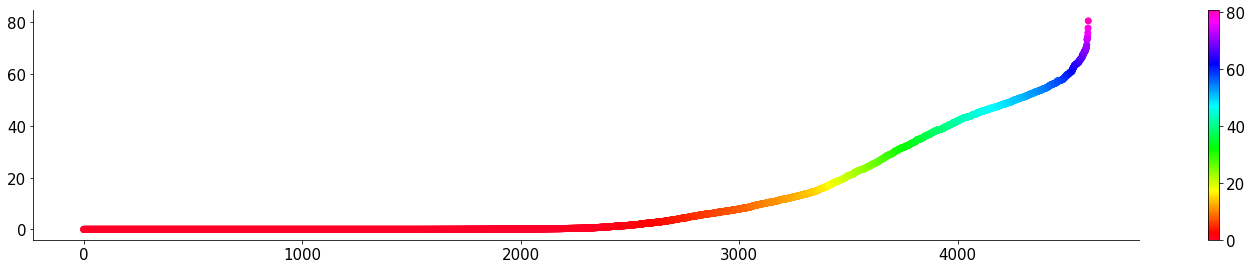

In [ ]:
plt.scatter(np.sort(np.arange(len(dat['run']))),np.sort(dat['run']), c = np.sort(dat['run']),cmap='gist_rainbow')
plt.colorbar()

In [ ]:
# z score the data before taking the PCA
z_data = scipy.stats.zscore(dat['sresp'],axis=1)

In [ ]:
pca = sklearn.decomposition.PCA(n_components=200,random_state=1)

In [ ]:
pca.fit(z_data.T)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
z_transform = pca.transform(z_data.T)

In [ ]:
z_transform.shape

(4598, 200)

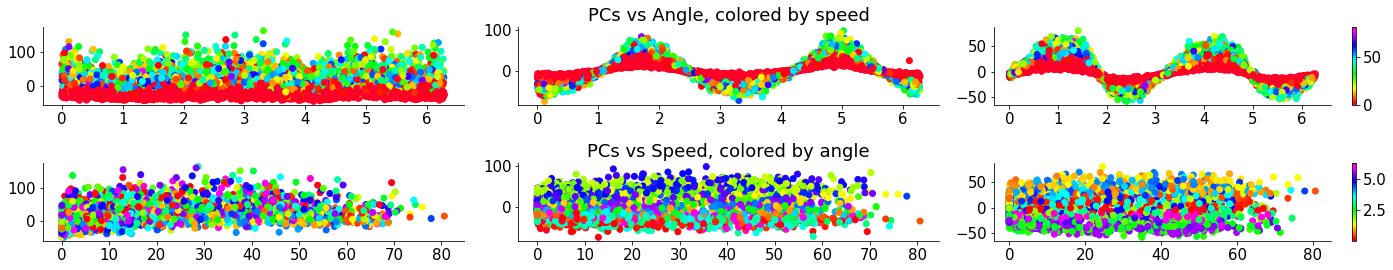

In [ ]:
plt.subplot(2,3,1)
plt.scatter(dat['istim'],z_transform[:,0], c = dat['run'],cmap = 'gist_rainbow')
plt.subplot(2,3,2)
plt.scatter(dat['istim'],z_transform[:,1], c = dat['run'],cmap = 'gist_rainbow')
plt.title('PCs vs Angle, colored by speed')
plt.subplot(2,3,3)
plt.scatter(dat['istim'],z_transform[:,2], c = dat['run'],cmap = 'gist_rainbow')
plt.colorbar()

plt.subplot(2,3,4)
plt.scatter(dat['run'],z_transform[:,0], c = dat['istim'],cmap = 'gist_rainbow')
plt.subplot(2,3,5)
plt.scatter(dat['run'],z_transform[:,1], c = dat['istim'],cmap = 'gist_rainbow')
plt.title('PCs vs Speed, colored by angle')
plt.subplot(2,3,6)
plt.scatter(dat['run'],z_transform[:,2], c = dat['istim'],cmap = 'gist_rainbow')
plt.colorbar()

Looking at linearity of the data in PC space:
- Of course it isn't linear

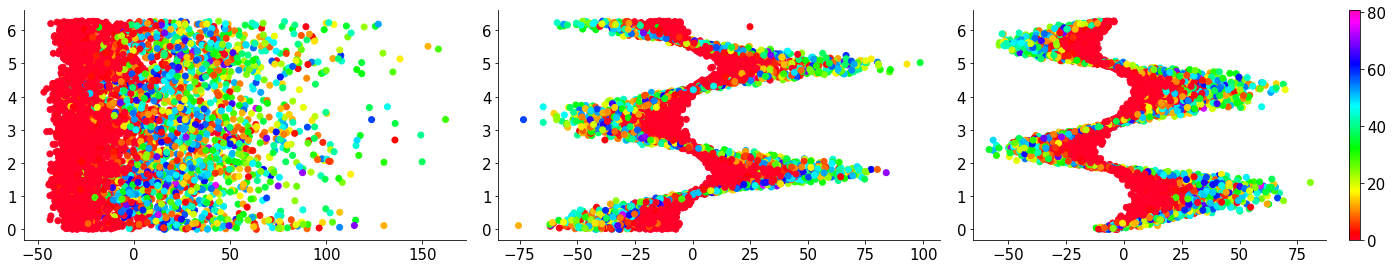

In [ ]:

plt.subplot(1,3,1)
plt.scatter(z_transform[:,0],dat['istim'], c = dat['run'],cmap = 'gist_rainbow')
plt.subplot(1,3,2)
plt.scatter(z_transform[:,1],dat['istim'], c = dat['run'],cmap = 'gist_rainbow')
plt.subplot(1,3,3)
plt.scatter(z_transform[:,2],dat['istim'], c = dat['run'],cmap = 'gist_rainbow')
plt.colorbar()

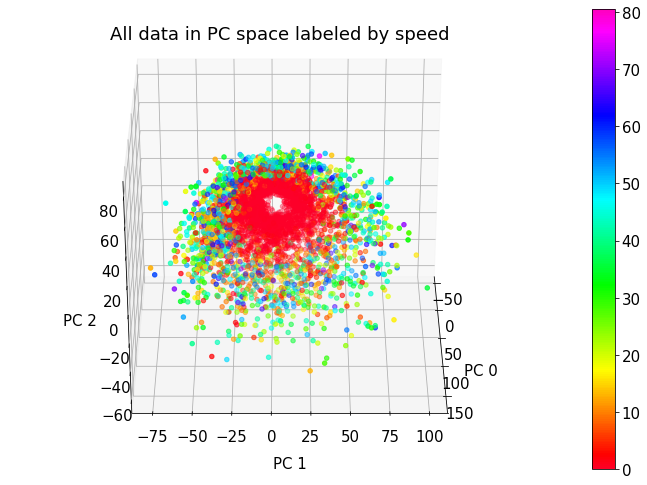

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform[:,0],z_transform[:,1],z_transform[:,2],c = dat['run'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in PC space labeled by speed ')
fig.colorbar(p)
ax.view_init(30,360)

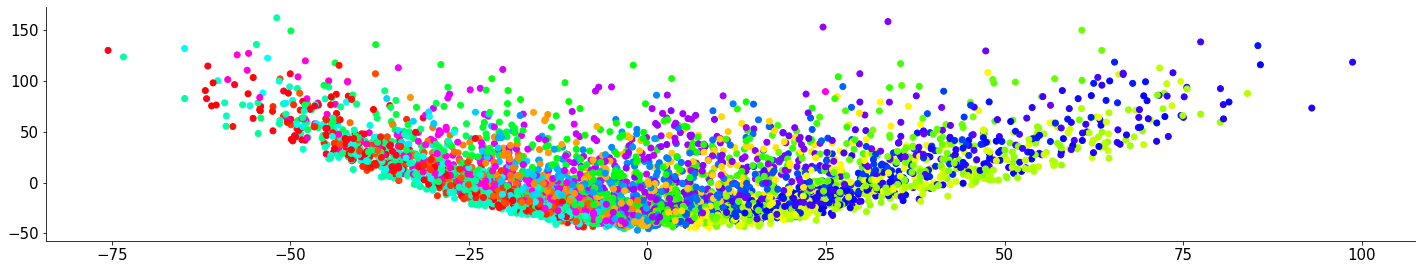

In [ ]:
plt.scatter(z_transform[:,1],z_transform[:,0],c = dat['istim'],cmap='gist_rainbow')

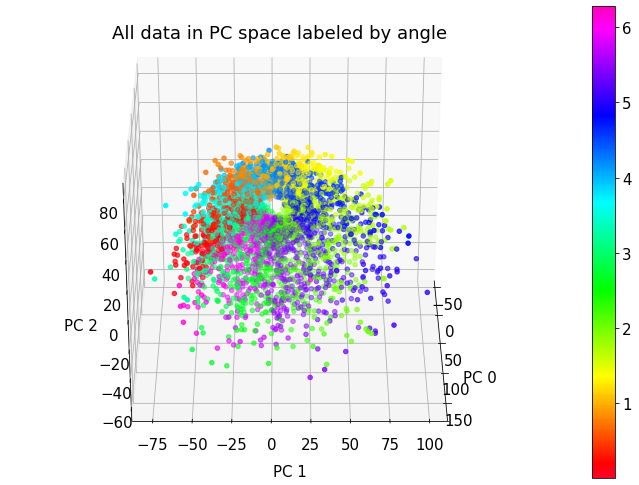

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform[:,0],z_transform[:,1],z_transform[:,2],c = dat['istim'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

Split the data from approximataly 0 to $\pi$ and $\pi$ to $2\pi$

In [ ]:
# 1s are greater than 3, 0 is less than 3 radians (to split from 0 to pi and pi to 2pi)
half_binary = dat['istim'] >3 # use 10 as the cutoff by looking at the split in the PCs above
all_idx = np.arange(len(dat['istim'])) 
second_idx = np.nonzero(half_binary)
first_idx = np.setdiff1d(all_idx,second_idx)

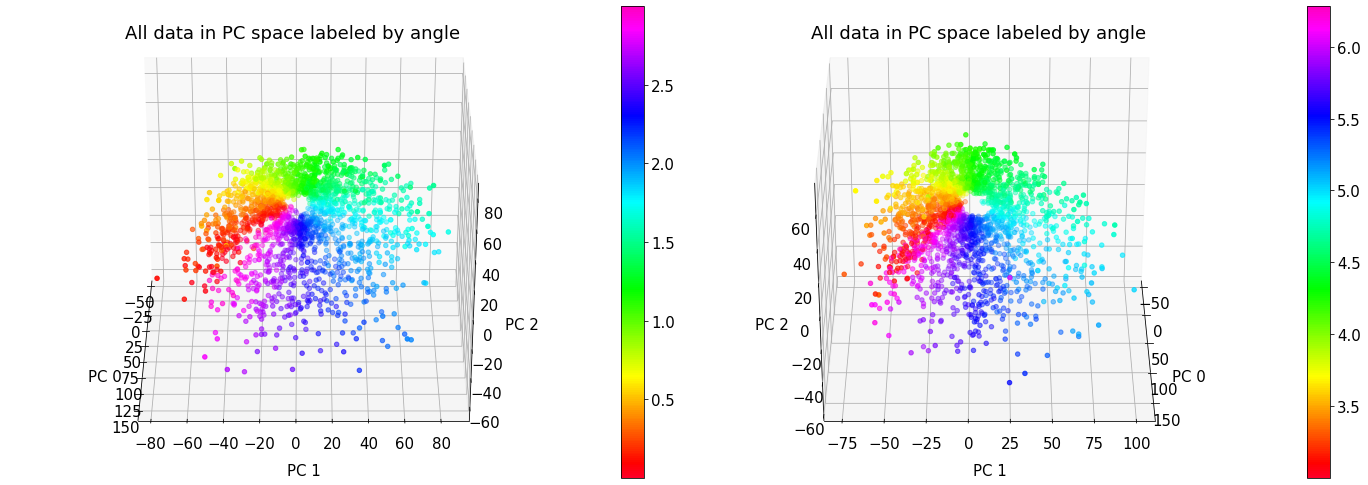

In [ ]:

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,2,1,projection='3d')
p1 = ax.scatter(z_transform[first_idx,0],z_transform[first_idx,1],z_transform[first_idx,2],c =dat['istim'][first_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in PC space labeled by angle ')
fig.colorbar(p1)
ax.view_init(30,360)


ax = fig.add_subplot(1,2,2,projection='3d')
p2 = ax.scatter(z_transform[second_idx,0],z_transform[second_idx,1],z_transform[second_idx,2],c =dat['istim'][second_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in PC space labeled by angle ')
fig.colorbar(p2)
ax.view_init(30,360)

### Get the indices of the data where running is >10 and <10

In [5]:
# 1s are running, 0 is standing
speed_binary = dat['run'] >10 # use 10 as the cutoff by looking at the split in the PCs above
all_speed_idx = np.arange(len(dat['run'])) 
running_idx = np.nonzero(speed_binary)
standing_idx = np.setdiff1d(all_speed_idx,running_idx)

In [ ]:
# There are many more standing trials than running trials, so randomly sample from the standing trials to get
# the same number as the running trials
standing_idx_cut = np.random.choice(standing_idx,len(running_idx[0]))

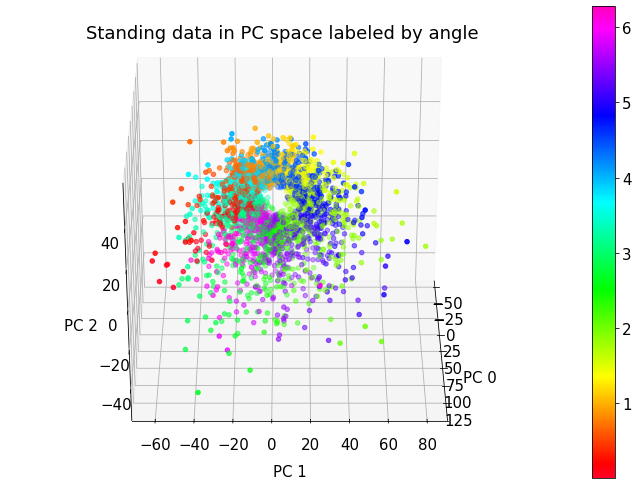

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform[standing_idx,0],z_transform[standing_idx,1],z_transform[standing_idx,2],c = dat['istim'][standing_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('Standing data in PC space labeled by angle')
fig.colorbar(p)
ax.view_init(30,360)

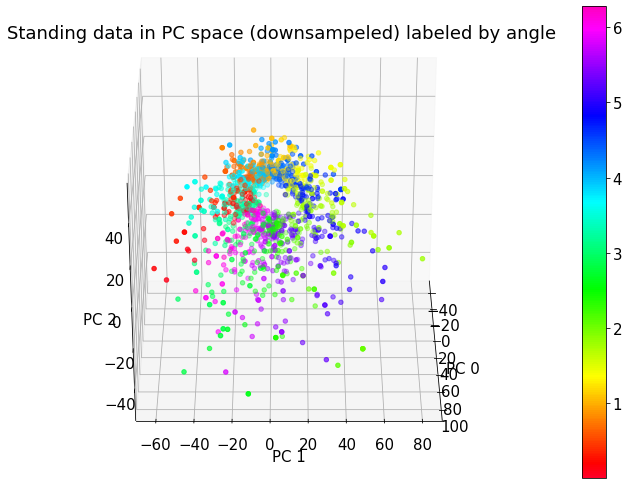

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform[standing_idx_cut,0],z_transform[standing_idx_cut,1],z_transform[standing_idx_cut,2],c = dat['istim'][standing_idx_cut],cmap='gist_rainbow')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Standing data in PC space (downsampeled) labeled by angle')
fig.colorbar(p)
ax.view_init(30,360)

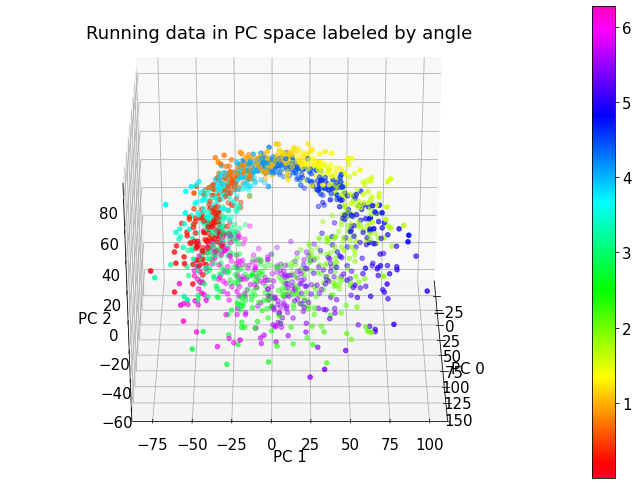

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform[running_idx[0],0],z_transform[running_idx[0],1],z_transform[running_idx[0],2],c = dat['istim'][running_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Running data in PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

# PCA on split running and standing data

In [ ]:
z_data_stand = scipy.stats.zscore(dat['sresp'][:,standing_idx_cut],axis=1)

In [ ]:
z_data_stand.shape

(23589, 1481)

In [ ]:
pca_stand = sklearn.decomposition.PCA(n_components=200,random_state=1)

In [ ]:
pca_stand.fit(z_data_stand.T)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
z_transform_stand = pca_stand.transform(z_data_stand.T)

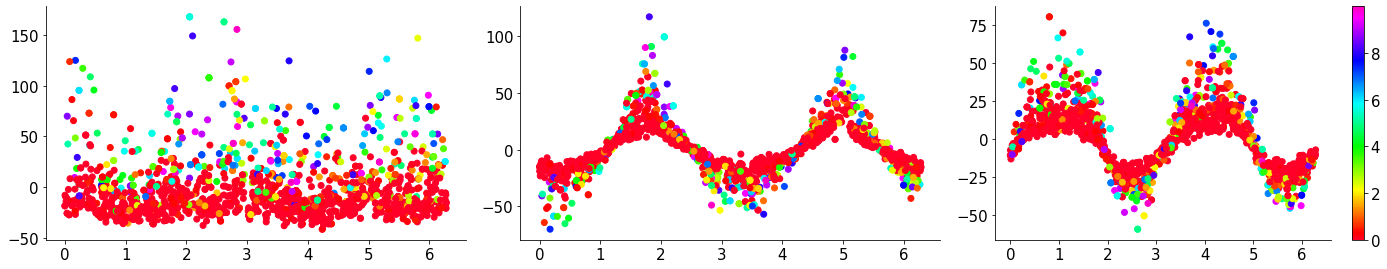

In [ ]:
plt.subplot(1,3,1)
plt.scatter(dat['istim'][standing_idx_cut],z_transform_stand[:,0], c = dat['run'][standing_idx_cut],cmap = 'gist_rainbow')
plt.subplot(1,3,2)
plt.scatter(dat['istim'][standing_idx_cut],z_transform_stand[:,1], c = dat['run'][standing_idx_cut],cmap = 'gist_rainbow')
plt.subplot(1,3,3)
plt.scatter(dat['istim'][standing_idx_cut],z_transform_stand[:,2], c = dat['run'][standing_idx_cut],cmap = 'gist_rainbow')
plt.colorbar()

# plt.subplot(2,3,4)
# plt.scatter(dat['run'],z_transform[:,0], c = dat['istim'],cmap = 'gist_rainbow')
# plt.subplot(2,3,5)
# plt.scatter(dat['run'],z_transform[:,1], c = dat['istim'],cmap = 'gist_rainbow')
# plt.subplot(2,3,6)
# plt.scatter(dat['run'],z_transform[:,2], c = dat['istim'],cmap = 'gist_rainbow')
# plt.colorbar()

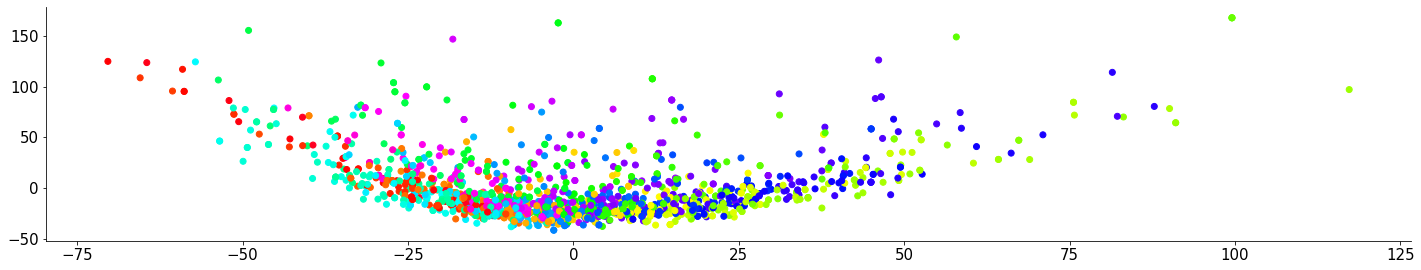

In [ ]:
plt.scatter(z_transform_stand[:,1],z_transform_stand[:,0],c = dat['istim'][standing_idx_cut],cmap='gist_rainbow')

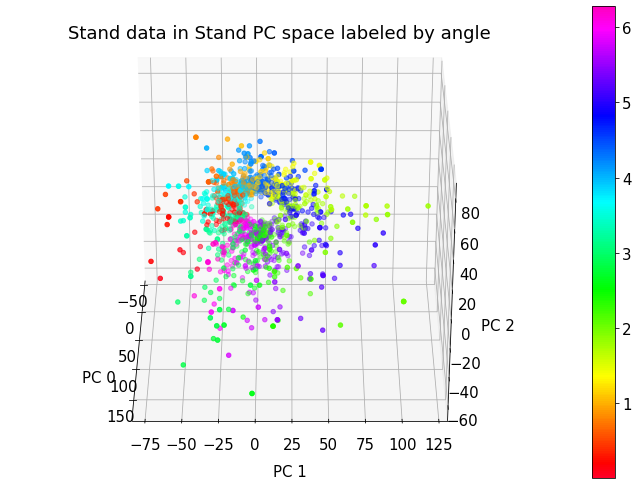

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_stand[:,0],z_transform_stand[:,1],z_transform_stand[:,2],c = dat['istim'][standing_idx_cut],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('Stand data in Stand PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

In [ ]:
z_data_run = scipy.stats.zscore(dat['sresp'][:,running_idx[0]],axis=1)

In [ ]:
z_data_run.shape

(23589, 1481)

In [ ]:
pca_run = sklearn.decomposition.PCA(n_components=200,random_state=1)

In [ ]:
pca_run.fit(z_data_run.T)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
z_transform_run = pca_run.transform(z_data_run.T)

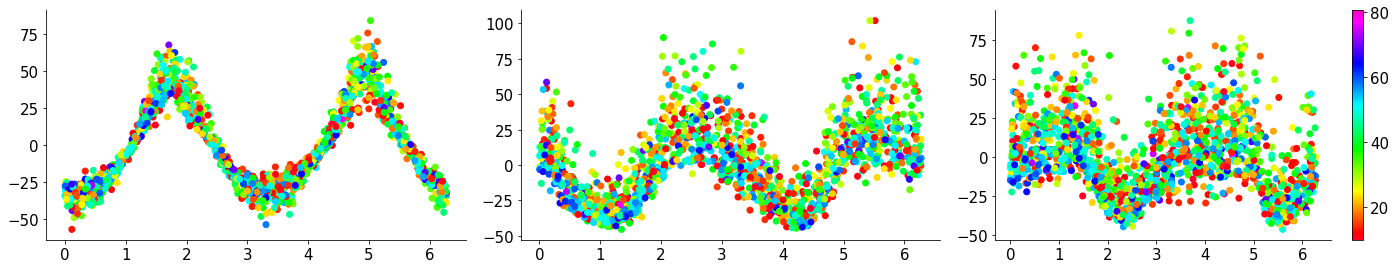

In [ ]:
plt.subplot(1,3,1)
plt.scatter(dat['istim'][running_idx],z_transform_run[:,0], c = dat['run'][running_idx],cmap = 'gist_rainbow')
plt.subplot(1,3,2)
plt.scatter(dat['istim'][running_idx],z_transform_run[:,1], c = dat['run'][running_idx],cmap = 'gist_rainbow')
plt.subplot(1,3,3)
plt.scatter(dat['istim'][running_idx],z_transform_run[:,2], c = dat['run'][running_idx],cmap = 'gist_rainbow')
plt.colorbar()

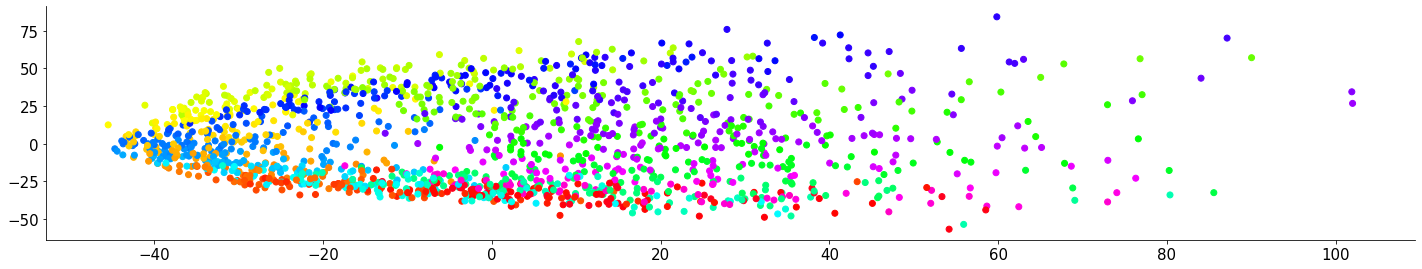

In [ ]:
plt.scatter(z_transform_run[:,1],z_transform_run[:,0],c = dat['istim'][running_idx],cmap='gist_rainbow')

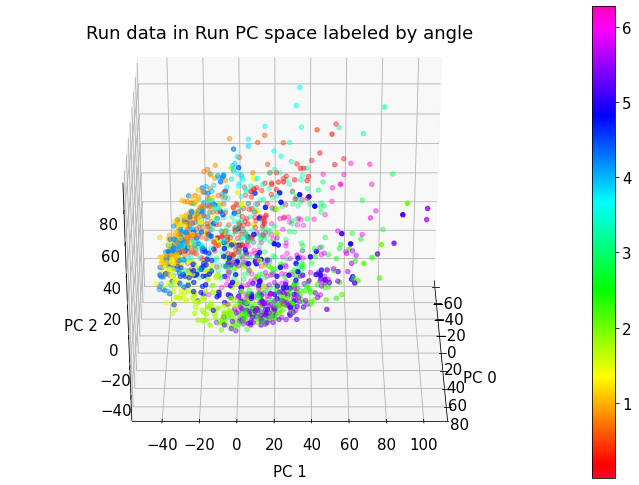

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_run[:,0],z_transform_run[:,1],z_transform_run[:,2],c = dat['istim'][running_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('Run data in Run PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

In [ ]:
z_transform_standinrun = pca_run.transform(z_data_stand.T)

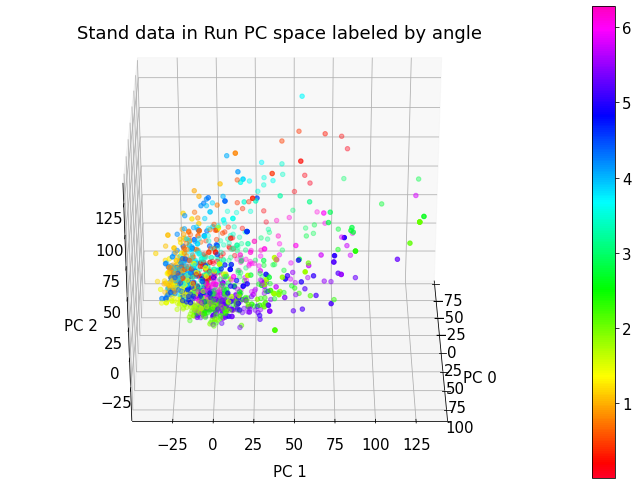

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_standinrun[:,0],z_transform_standinrun[:,1],z_transform_standinrun[:,2],c = dat['istim'][standing_idx_cut],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('Stand data in Run PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

In [ ]:
z_transform_runinstand = pca_stand.transform(z_data_run.T)

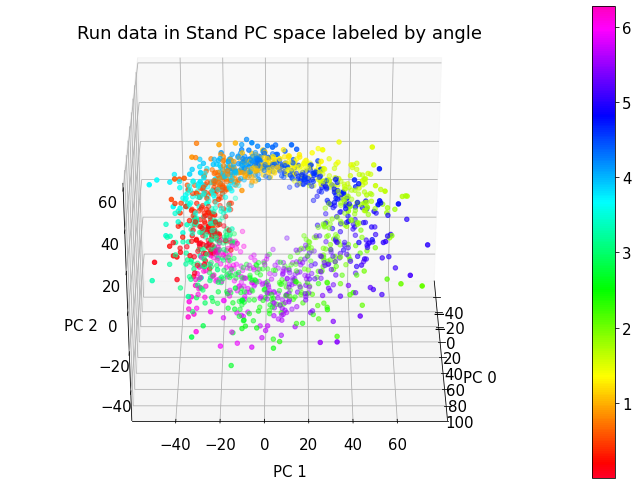

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_runinstand[:,0],z_transform_runinstand[:,1],z_transform_runinstand[:,2],c = dat['istim'][running_idx],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('Run data in Stand PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

In [ ]:
z_transform_allinstand = pca_stand.transform(z_data.T)

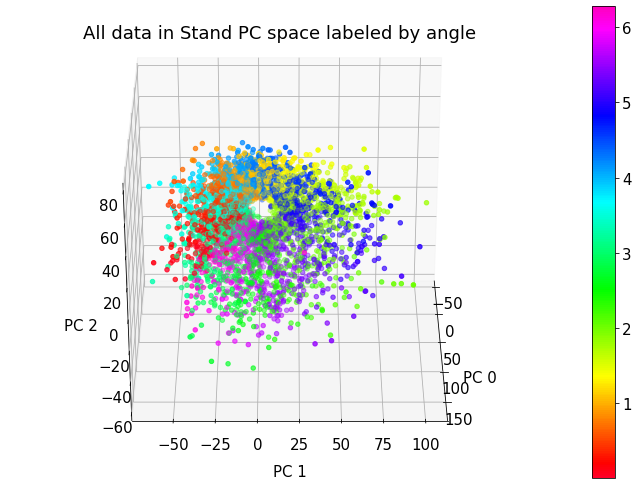

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_allinstand[:,0],z_transform_allinstand[:,1],z_transform_allinstand[:,2],c = dat['istim'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in Stand PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

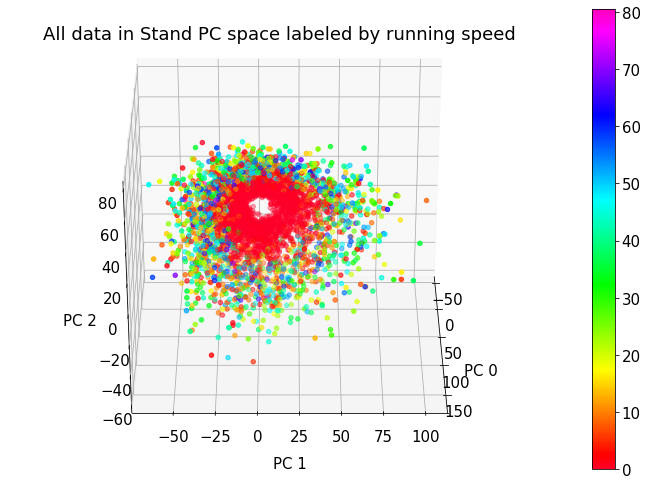

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_allinstand[:,0],z_transform_allinstand[:,1],z_transform_allinstand[:,2],c = dat['run'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in Stand PC space labeled by running speed ')
fig.colorbar(p)
ax.view_init(30,360)

In [ ]:
z_transform_allinrun = pca_run.transform(z_data.T)

Looks like it's rotated

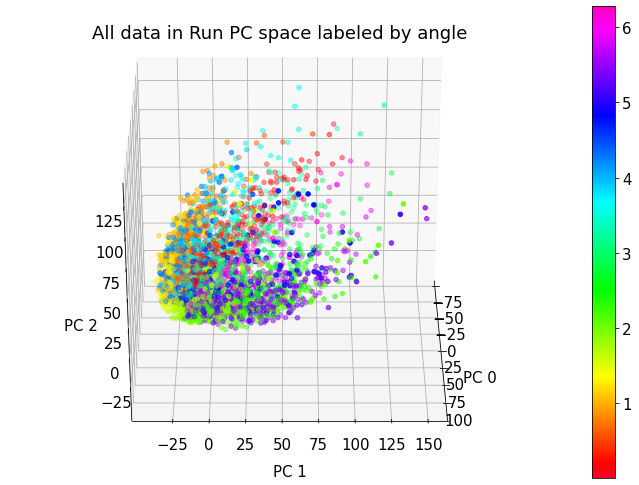

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_allinrun[:,0],z_transform_allinrun[:,1],z_transform_allinrun[:,2],c = dat['istim'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in Run PC space labeled by angle ')
fig.colorbar(p)
ax.view_init(30,360)

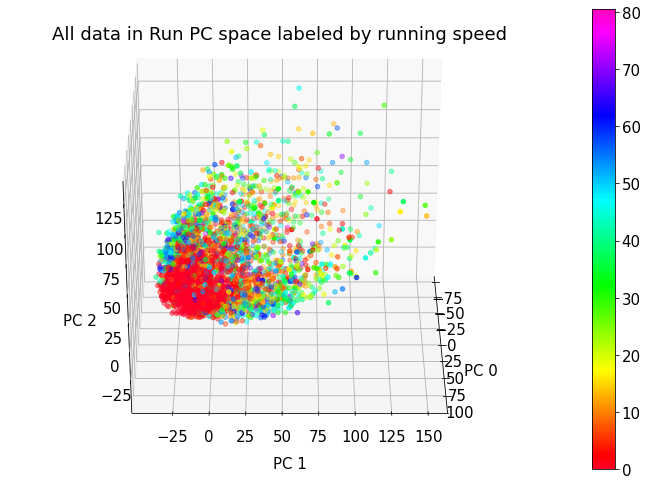

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(z_transform_allinrun[:,0],z_transform_allinrun[:,1],z_transform_allinrun[:,2],c = dat['run'],cmap='gist_rainbow')
ax.set_xlabel('PC 0',labelpad = 15)
ax.set_ylabel('PC 1',labelpad = 15)
ax.set_zlabel('PC 2',labelpad = 15)
plt.title('All data in Run PC space labeled by running speed ')
fig.colorbar(p)
ax.view_init(30,360)

# Linear Regression

To make any claims, these results would need to be cross-validated

In [ ]:
def regress_pcs(z_transform,y):
  train_size = 0.7


  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(z_transform, y,
                                                                              train_size=train_size, random_state=1)
  reg_pc = sklearn.linear_model.LinearRegression()
  reg_pc.fit(X_train,y_train)
  y_pred_train = reg_pc.predict(X_train)
  y_pred_test = reg_pc.predict(X_test)
  r_train = sklearn.metrics.r2_score(y_train,y_pred_train)
  r_test = sklearn.metrics.r2_score(y_test,y_pred_test)
  mse_train = sklearn.metrics.mean_squared_error(y_train, y_pred_train)
  mean_error_train = np.sqrt(mse_train)
  mse_test = sklearn.metrics.mean_squared_error(y_test, y_pred_test)
  mean_error_test = np.sqrt(mse_test)
  return y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test


Linear regression on all the neurons -> overfitting

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_data.T,dat['istim'])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(1.0, 'Our model has an average train error of 0.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.8554915441646147, 'Our model has an average test error of 40.0 degrees')

Linear regression on the transformed data (200 components) angles

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform,dat['istim'])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(0.8335937152045789, 'Our model has an average train error of 42.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.7739778075991808, 'Our model has an average test error of 50.0 degrees')

Linear regression on the transformed data (200 components) speed

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform,dat['run'])

In [ ]:
r_train,mean_error_train

(0.8754351406502979, 6.582809045669102)

In [ ]:
r_test,mean_error_test

(0.8041480746863063, 8.31206414508902)

Linear regression on the transformed data (200 components) angles using only standing trials

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform_stand,dat['istim'][standing_idx_cut])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(0.8466693262840425, 'Our model has an average train error of 40.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.524938184149276, 'Our model has an average test error of 69.0 degrees')

Linear regression on standing from all pc space

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform[standing_idx_cut],dat['istim'][standing_idx_cut])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(0.8656392636757564, 'Our model has an average train error of 38.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.6988333819977628, 'Our model has an average test error of 55.0 degrees')

Linear regression on the transformed data (200 components) angles using only running trials

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform_run,dat['istim'][running_idx])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(0.8952611998197934, 'Our model has an average train error of 34.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.8180374520403898, 'Our model has an average test error of 45.0 degrees')

Linear regression on running from all pc space

In [ ]:
y_train,y_test,y_pred_train,y_pred_test,r_train,r_test,mean_error_train,mean_error_test = regress_pcs(z_transform[running_idx],dat['istim'][running_idx])

In [ ]:
r_train,f"""Our model has an average train error of {round(360 * mean_error_train / (np.pi * 2))} degrees"""


(0.8970400833814438, 'Our model has an average train error of 33.0 degrees')

In [ ]:
r_test,f"""Our model has an average test error of {round(360 * mean_error_test / (np.pi * 2))} degrees"""


(0.8401555292845019, 'Our model has an average test error of 42.0 degrees')

# Bayesian Linear Regression

Just an experiment

The purpose of this is to use bayesian linear regression to see if there is more uncertainty in our estimate of the angle given neural data transformed into PC space when we use running or non-running trials. But I couldn't really test that because the weights were all close to zero mean and sd.

In [ ]:
!pip install pymc3==3.8

In [ ]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [ ]:
# running data
y = dat['istim'][running_idx]
X = z_transform[running_idx[0],0:3]

In [ ]:
# bayesian linear regression model, assumes gaussian noise
basic_model = pm.Model()
with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=3)
    # I think this is where we impose the gaussian noise assumption 
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X,beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

In [ ]:
with basic_model:
    # draw 2000 posterior samples
    trace = pm.sample(5000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:08<00:00, 693.93it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  func(*args, **kwargs)


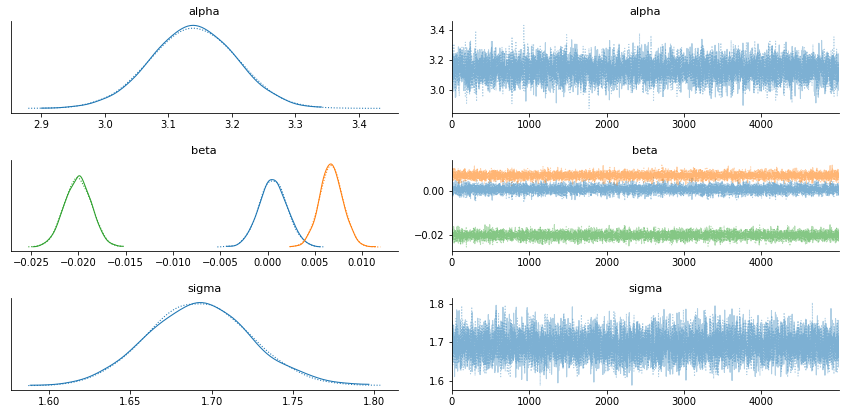

In [ ]:
pm.traceplot(trace);

In [ ]:
pm.summary(trace).round(2)


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,3.14,0.07,3.02,3.27,0.0,0.0,7067.0,7067.0,7084.0,5785.0,1.0
beta[0],0.00,0.00,-0.00,0.00,0.0,0.0,6995.0,4754.0,7036.0,5635.0,1.0
beta[1],0.01,0.00,0.00,0.01,0.0,0.0,11251.0,10898.0,11273.0,7884.0,1.0
beta[2],-0.02,0.00,-0.02,-0.02,0.0,0.0,8866.0,8862.0,8862.0,7195.0,1.0
sigma,1.69,0.03,1.64,1.75,0.0,0.0,10037.0,9989.0,10117.0,7323.0,1.0
